# Import Libraries

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Obtain data

Read weekly oil production csv into pandas

In [64]:
production_df = pd.read_excel('Data/oil_production.xls', header=2, sheet_name='Data 1')
production_df.head()

,Date,Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day)
0,1983-01-07,8634
1,1983-01-14,8634
2,1983-01-21,8634
3,1983-01-28,8634
4,1983-02-04,8660


Read weekly oil price csv into pandas

In [65]:
prices_df = pd.read_excel('Data/oil_prices.xls', header=2, sheet_name='Data 1')
prices_df.head()

,Date,"Weekly Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,1986-01-03,25.78
1,1986-01-10,25.99
2,1986-01-17,24.57
3,1986-01-24,20.31
4,1986-01-31,19.69


Merge dfs with oil price and oil production time series data

In [66]:
df = pd.merge(prices_df, production_df, how='outer', on='Date')
df.head()

,Date,"Weekly Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day)
0,1986-01-03,25.78,8942
1,1986-01-10,25.99,8942
2,1986-01-17,24.57,8942
3,1986-01-24,20.31,8942
4,1986-01-31,19.69,8942


Filter df for relevant time series period 

In [67]:
df = df[df['Date']>='2011-8-12']
df.reset_index(drop=True, inplace=True)
df.columns = ['Date', 'Oil Price', 'Oil Production']
df.head()

,Date,Oil Price,Oil Production
0,2011-08-12,82.86,5561
1,2011-08-19,85.36,5591
2,2011-08-26,85.06,5598
3,2011-09-02,88.07,5642
4,2011-09-09,87.91,5083


# Scrub Data

Use df.info() to confirm no missing values and correct data types

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            486 non-null    datetime64[ns]
 1   Oil Price       486 non-null    float64       
 2   Oil Production  486 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.5 KB


Plot df to look for outliers

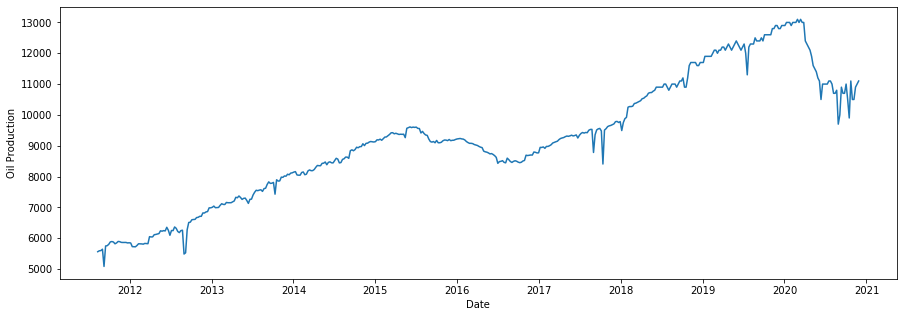

In [69]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Date', y='Oil Production', data=df, ax=ax)

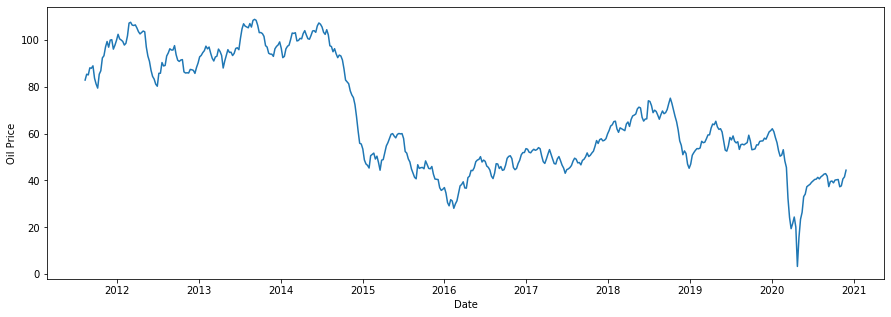

In [70]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Date', y='Oil Price', data=df, ax=ax)

# EDA?

In [71]:
df['Diff Oil Production'] = df['Oil Production'].diff(1)
df.head()

,Date,Oil Price,Oil Production,Diff Oil Production
0,2011-08-12,82.86,5561,NaN
1,2011-08-19,85.36,5591,30.0
2,2011-08-26,85.06,5598,7.0
3,2011-09-02,88.07,5642,44.0
4,2011-09-09,87.91,5083,-559.0


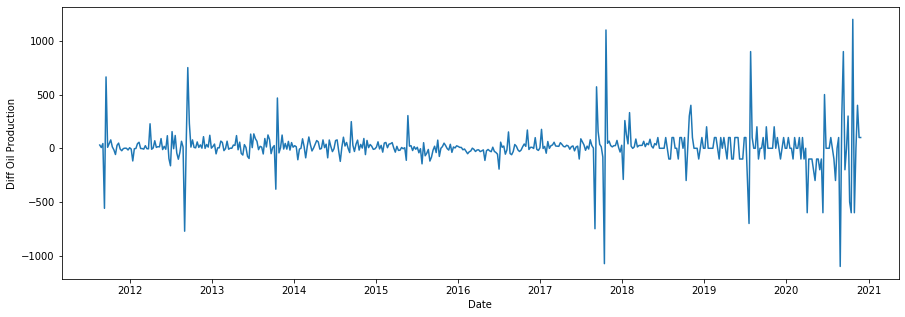

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Date', y='Diff Oil Production', data=df.iloc[1:], ax=ax)

In [73]:
adfuller(df['Diff Oil Production'][1:])

(-4.488526028920253,
 0.00020624329789417395,
 11,
 473,
 {'1%': -3.444250937448703,
  '5%': -2.867669873870454,
  '10%': -2.5700349866579657},
 6086.315656541832)

Text(0, 0.5, 'Correlation')

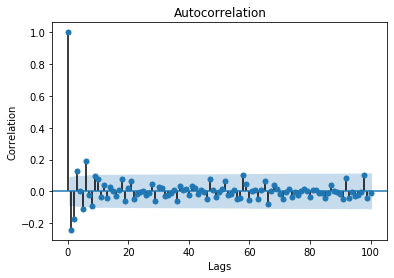

In [74]:
fig, ax = plt.subplots()
plot_acf(df['Diff Oil Production'][1:], alpha=.05, lags = 100, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Text(0, 0.5, 'Correlation')

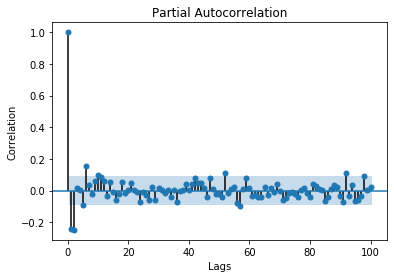

In [75]:
fig, ax = plt.subplots()
plot_pacf(df['Diff Oil Production'][1:], alpha=.05, lags = 100, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

# Modeling

In [111]:
train_series = df['Diff Oil Production'].values[1:455]
val_series = df['Diff Oil Production'].values[455:]

In [112]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 227.86298698747038
Train MAE: 106.95364238410596
Validation RMSE: 702.1395872616783
Validation MAE: 470.0


In [113]:
train_mean_predictions = [train_series.mean()]*454
train_mean_actuals = train_series
val_mean_predictions = val_series
val_mean_actuals = [train_series.mean()]*31
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_mean_actuals, val_mean_predictions)))
print('Validation MAE:', mean_absolute_error(val_mean_actuals, val_mean_predictions))

Train RMSE: 227.86298698747038
Train MAE: 106.95364238410596
Validation RMSE: 432.3692075523708
Validation MAE: 295.43335228080144


In [114]:
sarima = SARIMAX(train_series, order = (4,0,4), exog=df['Oil Price'].values[1:455])
sarima_model = sarima.fit()
print(sarima_model.summary())
print(sarima_model.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  454
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -2875.045
Date:                Fri, 04 Dec 2020   AIC                           5770.090
Time:                        20:01:49   BIC                           5811.271
Sample:                             0   HQIC                          5786.315
                                - 454                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2385      0.076      3.150      0.002       0.090       0.387
ar.L1         -0.7756      0.613     -1.265      0.206      -1.977       0.426
ar.L2          0.5877      0.944      0.622      0.5

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [93]:
val_pred_sarima = sarima_model.forecast(steps=31, exog=df['Oil Price'].values[455:])
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarima))

Validation RMSE: 434.492304531423
Validation MAE: 299.16012402834724


In [100]:
df_pred = df.iloc[455:,:]
df_pred['Oil Production Pred'] = val_pred_sarima

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


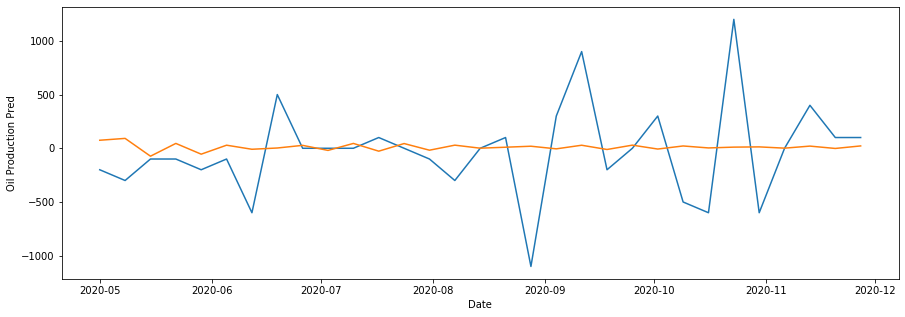

In [102]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Date', y='Diff Oil Production', data=df.iloc[455:], ax=ax)
sns.lineplot(x='Date', y='Oil Production Pred', data=df_pred, ax=ax)

In [106]:
val_pred_sarima

array([ 74.69905131,  91.91922551, -73.70494105,  45.17549768,
       -54.89788977,  28.587079  ,  -9.21926884,   2.50118094,
        27.13459436, -19.85493211,  45.16732316, -26.99952371,
        43.99844605, -17.93979869,  29.0228347 ,   0.74244962,
         9.85028438,  19.06107247,  -5.3447573 ,  28.25479882,
       -11.30145315,  29.12734771,  -7.19008552,  21.44591962,
         3.16021328,  10.60669553,  12.88645344,   1.07980321,
        20.1882294 ,  -1.69666605,  21.86489038])

In [76]:
df[df['Date']=='2020-5-1']

,Date,Oil Price,Oil Production,Diff Oil Production
455,2020-05-01,15.71,11900,-200.0


In [22]:
df['Date'].values[-1]

numpy.datetime64('2020-11-27T00:00:00.000000000')

In [62]:
df.head()

,Date,Oil Price,Oil Production,Diff Oil Production
1336,2011-08-12,82.86,5561,NaN
1337,2011-08-19,85.36,5591,30.0
1338,2011-08-26,85.06,5598,7.0
1339,2011-09-02,88.07,5642,44.0
1340,2011-09-09,87.91,5083,-559.0


In [105]:
sarima_model

,Date,Oil Price,Oil Production,Diff Oil Production
1336,2011-08-12,82.86,5561,NaN
1337,2011-08-19,85.36,5591,30.0
1338,2011-08-26,85.06,5598,7.0
1339,2011-09-02,88.07,5642,44.0
1340,2011-09-09,87.91,5083,-559.0


In [25]:
adfuller(df['Diff Oil Production'][1:])

(-9.44535717185381,
 4.771861805815455e-16,
 5,
 431,
 {'1%': -3.445613745346461,
  '5%': -2.868269325317112,
  '10%': -2.5703544951308404},
 5276.721401126038)

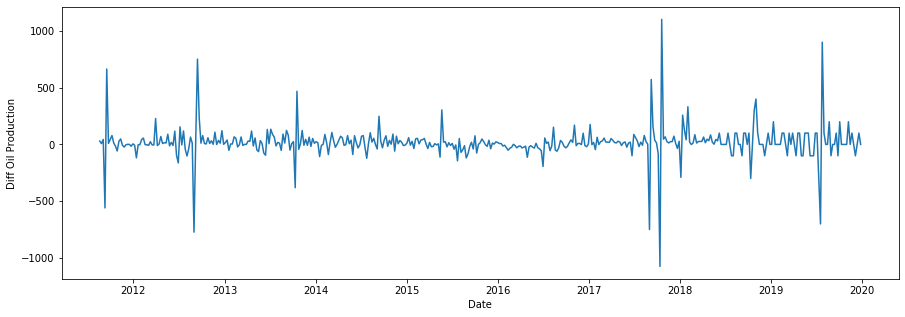